In [52]:
# Hidden Config Cell

#!python -m pip install -e ../../../../Maccabee > /dev/null

from maccabee.constants import Constants
from maccabee.data_sources.data_source_builders import build_random_normal_datasource
from maccabee.benchmarking import benchmark_model_using_sampled_dgp_grid
from maccabee.modeling.models import LinearRegressionCausalModel

from functools import partial

LOW, MEDIUM, HIGH = Constants.AxisLevels.LEVELS

param_grid = {
    Constants.AxisNames.TREATMENT_NONLINEARITY: [HIGH],
    Constants.AxisNames.OUTCOME_NONLINEARITY: [HIGH]
}

normal_data_source = build_random_normal_datasource(
    n_covars=20,
    n_observations=100)
    
run_benchmark = partial(benchmark_model_using_sampled_dgp_grid,
    model_class=LinearRegressionCausalModel,
    estimand=Constants.Model.ATE_ESTIMAND,
    data_source=normal_data_source,
    dgp_param_grid=param_grid)

run_parallelization_benchmark = partial(
    run_benchmark,
    num_dgp_samples=16,
    num_sampling_runs_per_dgp=1,
    num_samples_from_dgp=5)

run_compilation_benchmark = partial(
    run_benchmark,
    num_dgp_samples=1,
    num_sampling_runs_per_dgp=1,
    n_jobs=8)

In [54]:
%%time

_ = run_parallelization_benchmark(n_jobs=1)

CPU times: user 12.4 s, sys: 487 ms, total: 12.9 s
Wall time: 1min 10s


In [53]:
%%time

_ = run_parallelization_benchmark(n_jobs=4)

CPU times: user 11.7 s, sys: 554 ms, total: 12.3 s
Wall time: 34 s


In [ ]:
from time import time
from collections import defaultdict

N_samples = [10, 50, 100, 200, 500]
times = defaultdict(list)
for n_samples in N_samples:
    for compiled in [True, False]:
        s = time()
        run_compilation_benchmark(
            num_samples_from_dgp=n_samples,
            compile_functions=compiled)
        e = time()
        exec_time = e - s
        times[compiled].append(exec_time)


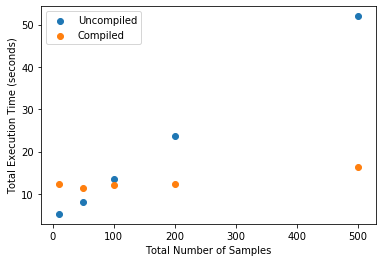

In [48]:
import matplotlib.pyplot as plt

plt.scatter(N_samples, times[False], label="Uncompiled")
plt.scatter(N_samples, times[True], label="Compiled")
plt.legend()
plt.ylabel("Total Execution Time (seconds)")
plt.xlabel("Total Number of Samples")
plt.show()